# Regret Matching Agent Training and Saving Pipeline

This notebook trains Regret Matching (RM) agents for a variety of simultaneous games.
For each game, it:
1. Initializes the game environment and RM agents.
2. Trains the agents over a specified number of episodes and iterations.
3. Saves the learned policy (average strategy) for each agent.
4. Saves the training data (e.g., average rewards per iteration) for later analysis.

The saved models and data will be stored in the `rm_trainings` directory, organized by game.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time # For potential rendering delays

# Game implementations
from games.rps import RPS
from games.mp import MP
from games.blotto import Blotto
from games.foraging import Foraging # Note: RM is typically for stateless games. Its direct application to Foraging might need careful consideration of state.

# Agent implementation
from agents.regretmatching_t import RegretMatching

# Base classes (if needed for type hinting or direct use)
from base.game import SimultaneousGame, AgentID, ActionDict

## 1. Define Games and Configurations

Specify the games to be tested and their respective configurations.
The `get_game_instance` helper function will be used to create game objects.

In [2]:
games_to_test = [
    {"name": "RPS", "game_class": RPS, "config": {}, "train_episodes": 1000, "train_iterations": 500},
    {"name": "MP", "game_class": MP, "config": {}, "train_episodes": 1000, "train_iterations": 500},
    {"name": "Blotto_S3_N2", "game_class": Blotto, "config": {"S": 3, "N": 2}, "train_episodes": 2000, "train_iterations": 1000},
    # Foraging is stateful; RM's standard form is for stateless games.
    # If used, ensure the regret calculation in the agent correctly handles this or is adapted.
    # For now, we'll include it but with a caveat.
    {"name": "Foraging_5x5_2p_1f", "game_class": Foraging, "config": {"config": "Foraging-5x5-2p-1f-v3", "seed": 42}, "train_episodes": 1000, "train_iterations": 500}
]

def get_game_instance(game_entry: dict) -> SimultaneousGame:
    """Creates a game instance from a game entry."""
    game_class = game_entry["game_class"]
    config = game_entry["config"]
    if game_entry["name"].startswith("Blotto") or game_entry["name"].startswith("Foraging"):
        return game_class(**config)
    else:
        return game_class()

# Directory to save training outputs
TRAINING_DATA_DIR = "rm_trainings"
if not os.path.exists(TRAINING_DATA_DIR):
    os.makedirs(TRAINING_DATA_DIR)
    print(f"Created directory: {TRAINING_DATA_DIR}")
else:
    print(f"Directory already exists: {TRAINING_DATA_DIR}")

Created directory: rm_trainings


## 2. Helper Functions for Agent Creation, Training, and Saving

In [3]:
def create_agents(game: SimultaneousGame, seed_base: int = 42) -> dict[AgentID, RegretMatching]:
    """Creates RegretMatching agents for all agents in the game."""
    agents = {}
    for i, agent_id in enumerate(game.agents):
        # RegretMatching takes the game, agent_id, and an optional seed.
        # It does not use a complex config object like IQLAgent.
        agent_seed = seed_base + i if seed_base is not None else None
        agents[agent_id] = RegretMatching(game=game, agent=agent_id, seed=agent_seed)
    return agents

def play_episode(game: SimultaneousGame, agents: dict[AgentID, RegretMatching], max_steps_per_episode=100, verbose=False, render=False):
    """Plays a single episode of the game with the given agents.
    For RM, the agent's internal state (regrets, policy) is updated when its action() method is called.
    The 'learn' parameter is not explicitly needed for RM's action method in the same way as IQL's update.
    """
    game.reset() # Resets game state, observations, rewards.
    # RM agents don't have a separate reset method in the provided code, their state persists across episodes within a training run.
    # The crucial part is that game.reset() clears rewards, so the first action() call in an episode won't update regrets from a previous episode's final state.

    cumulative_rewards = {agent_id: 0.0 for agent_id in game.agents}
    
    is_foraging = isinstance(game, Foraging)
    
    for step in range(max_steps_per_episode):
        if is_foraging and game.env.unwrapped._game_over:
            break
        # For matrix games, terminations become True after the first step.
        # The RM agent's action() method internally calls _update_internal_state_based_on_last_observation(),
        # which uses game.reward(self.agent) and game.observe(self.agent) from the *previous* step.
        # So, the sequence is:
        # 1. game.reset()
        # 2. (Loop) agents choose action (RM updates based on t-1) -> game.step() -> game state (rewards, obs) for t is set.
        
        # Agents choose actions. This also triggers their internal regret/policy updates based on the *previous* step's outcome.
        actions = {agent_id: agents[agent_id].action() for agent_id in game.agents}
        
        # Store the actions taken in this step, as RM agent might need it for counterfactuals if game.observe doesn't provide it.
        # The RM agent provided tries to get it from game.observe() or a fallback _last_joint_action_input.
        # To be safe, especially for the first step after reset where game.observe() might be None for some fields:
        if hasattr(game, '_last_joint_action_input'): # A potential convention from IQL notebook
             setattr(game, '_last_joint_action_input', actions.copy())

        game.step(actions) # This updates game.rewards, game.observations for the current step.

        for agent_id in game.agents:
            cumulative_rewards[agent_id] += game.reward(agent_id)
            # No explicit agent.update() call needed here for RM, as action() handles it.

        if verbose:
            print(f"  Step {step}: Actions: {actions}, Rewards: { {a: game.reward(a) for a in game.agents} }")
        
        if render:
            game.render()
            time.sleep(0.1)
            
        if all(game.terminations.values()) or (is_foraging and game.env.unwrapped._game_over):
            break
            
    return cumulative_rewards


def train_agents_for_game(game: SimultaneousGame, agents: dict[AgentID, RegretMatching], episodes: int, iterations: int, max_steps_per_episode=100):
    """Trains agents for a given game over multiple iterations and episodes."""
    print(f"Starting training for {game.__class__.__name__} with Regret Matching...")
    
    all_iterations_average_rewards = {agent_id: [] for agent_id in game.agents}

    # RM learns iteratively. Each call to action() is a learning step.
    # The concepts of "episodes" and "iterations" here mainly structure the data collection.
    # Total learning steps = iterations * episodes * steps_per_episode (for multi-step games)
    # Or iterations * episodes (for single-step games like RPS, MP, Blotto)

    for i in range(1, iterations + 1):
        iteration_total_rewards = {agent_id: 0.0 for agent_id in game.agents}
        for ep in range(episodes):
            episode_rewards = play_episode(game, agents, max_steps_per_episode=max_steps_per_episode, verbose=False)
            for agent_id in game.agents:
                iteration_total_rewards[agent_id] += episode_rewards[agent_id]
        
        for agent_id in game.agents:
            avg_reward_iteration = iteration_total_rewards[agent_id] / episodes
            all_iterations_average_rewards[agent_id].append(avg_reward_iteration)

        if i % (iterations // 10 or 1) == 0:
            current_policies_str = []
            for agent_id, agent_obj in agents.items():
                # policy_str = np.array2string(agent_obj.policy(), precision=2, formatter={'float_kind':lambda x: "%.2f" % x})
                # current_policies_str.append(f"Agent {agent_id} Policy: {policy_str}")
                # Simpler output for now:
                current_policies_str.append(f"Agent {agent_id} Avg Reward: {all_iterations_average_rewards[agent_id][-1]:.2f}")

            print(f"  Iteration {i}/{iterations} completed. {'; '.join(current_policies_str)}")
                
    print(f"Training completed for {game.__class__.__name__}.")
    return all_iterations_average_rewards


def save_agent_policy(agent: RegretMatching, game_name: str, agent_id_str: str, base_path: str):
    """Saves the learned policy (average strategy) of an agent to a file."""
    game_specific_path = os.path.join(base_path, game_name)
    if not os.path.exists(game_specific_path):
        os.makedirs(game_specific_path)
    
    file_path = os.path.join(game_specific_path, f"agent_{agent_id_str}_rm_policy.pkl")
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(agent.policy(), f) # agent.policy() returns the learned average strategy
        print(f"  Saved policy for agent {agent_id_str} to {file_path}")
    except Exception as e:
        print(f"  Error saving policy for agent {agent_id_str}: {e}")

def save_training_data(data: dict, game_name: str, base_path: str, filename="training_rewards_rm.pkl"):
    """Saves training data (e.g., rewards) to a file."""
    game_specific_path = os.path.join(base_path, game_name)
    if not os.path.exists(game_specific_path):
        os.makedirs(game_specific_path)
        
    file_path = os.path.join(game_specific_path, filename)
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(data, f)
        print(f"  Saved training data for {game_name} to {file_path}")
    except Exception as e:
        print(f"  Error saving training data for {game_name}: {e}")


## 3. Main Training Loop

Iterate through each game, train the agents, and save their learned policies and the training data.

In [4]:
# Max steps per episode can vary by game.
# Matrix games (RPS, MP, Blotto) are effectively 1-step from the perspective of a single interaction.
# RM updates based on the outcome of that single interaction.
GAME_MAX_STEPS = {
    "RPS": 1,
    "MP": 1,
    "Blotto_S3_N2": 1,
    "Foraging_5x5_2p_1f": 50 # Foraging might run for more steps. RM agent needs to handle state if game is stateful.
                            # The current RM agent is designed for stateless games where counterfactuals are from a reset state.
}


for game_entry in games_to_test:
    game_name = game_entry["name"]
    print(f"--- Training for game: {game_name} with Regret Matching ---")

    game_instance = get_game_instance(game_entry)
    
    # Create agents. Seed is handled in create_agents.
    agents = create_agents(game_instance, seed_base=42)

    episodes_per_iteration = game_entry["train_episodes"]
    num_iterations = game_entry["train_iterations"]
    max_steps = GAME_MAX_STEPS.get(game_name, 50) # Default if not specified

    # The RM agent learns continuously. `train_agents_for_game` will run play_episode multiple times.
    # Each call to agent.action() inside play_episode contributes to learning.
    training_rewards_history = train_agents_for_game(
        game_instance, 
        agents, 
        episodes=episodes_per_iteration, 
        iterations=num_iterations,
        max_steps_per_episode=max_steps
    )

    # Save policies and training data
    save_training_data(training_rewards_history, game_name, TRAINING_DATA_DIR, filename="training_rewards_rm.pkl")
    for agent_id, agent_obj in agents.items():
        agent_id_simple = str(game_instance.agent_name_mapping[agent_id])
        save_agent_policy(agent_obj, game_name, agent_id_simple, TRAINING_DATA_DIR)
        
    print(f"--- Finished training and saving for {game_name} ---")

print("All Regret Matching training processes completed.")

--- Training for game: RPS with Regret Matching ---
Starting training for RPS with Regret Matching...
  Iteration 50/500 completed. Agent agent_0 Avg Reward: -0.01; Agent agent_1 Avg Reward: 0.01
  Iteration 50/500 completed. Agent agent_0 Avg Reward: -0.01; Agent agent_1 Avg Reward: 0.01
  Iteration 100/500 completed. Agent agent_0 Avg Reward: 0.03; Agent agent_1 Avg Reward: -0.03
  Iteration 100/500 completed. Agent agent_0 Avg Reward: 0.03; Agent agent_1 Avg Reward: -0.03
  Iteration 150/500 completed. Agent agent_0 Avg Reward: -0.03; Agent agent_1 Avg Reward: 0.03
  Iteration 150/500 completed. Agent agent_0 Avg Reward: -0.03; Agent agent_1 Avg Reward: 0.03
  Iteration 200/500 completed. Agent agent_0 Avg Reward: 0.02; Agent agent_1 Avg Reward: -0.02
  Iteration 200/500 completed. Agent agent_0 Avg Reward: 0.02; Agent agent_1 Avg Reward: -0.02
  Iteration 250/500 completed. Agent agent_0 Avg Reward: -0.03; Agent agent_1 Avg Reward: 0.03
  Iteration 250/500 completed. Agent agent_0 

/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


  Iteration 50/500 completed. Agent agent_0 Avg Reward: 0.49; Agent agent_1 Avg Reward: 0.28
  Iteration 100/500 completed. Agent agent_0 Avg Reward: 0.47; Agent agent_1 Avg Reward: 0.31
  Iteration 100/500 completed. Agent agent_0 Avg Reward: 0.47; Agent agent_1 Avg Reward: 0.31
  Iteration 150/500 completed. Agent agent_0 Avg Reward: 0.47; Agent agent_1 Avg Reward: 0.29
  Iteration 150/500 completed. Agent agent_0 Avg Reward: 0.47; Agent agent_1 Avg Reward: 0.29
  Iteration 200/500 completed. Agent agent_0 Avg Reward: 0.48; Agent agent_1 Avg Reward: 0.28
  Iteration 200/500 completed. Agent agent_0 Avg Reward: 0.48; Agent agent_1 Avg Reward: 0.28
  Iteration 250/500 completed. Agent agent_0 Avg Reward: 0.47; Agent agent_1 Avg Reward: 0.28
  Iteration 250/500 completed. Agent agent_0 Avg Reward: 0.47; Agent agent_1 Avg Reward: 0.28
  Iteration 300/500 completed. Agent agent_0 Avg Reward: 0.49; Agent agent_1 Avg Reward: 0.28
  Iteration 300/500 completed. Agent agent_0 Avg Reward: 0.49

## 4. Plotting Training Results (Example)

This section demonstrates how to load and plot the saved training data (average rewards per iteration).

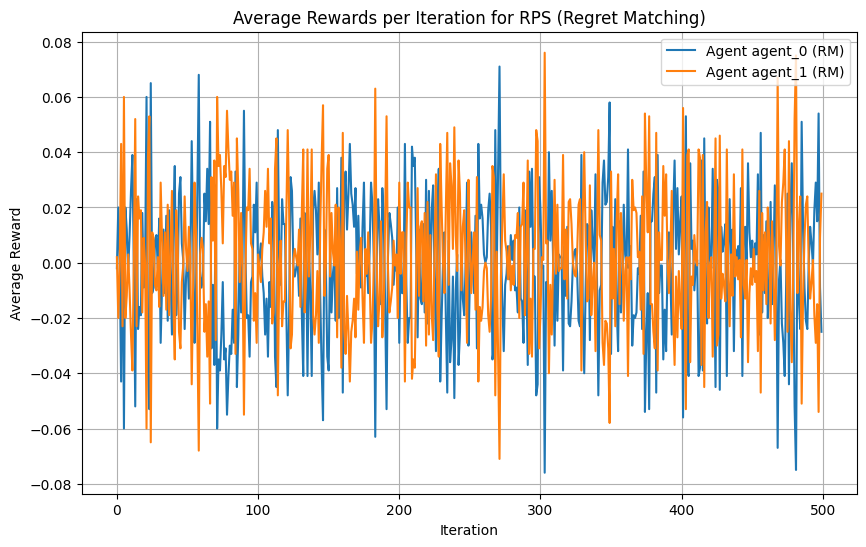

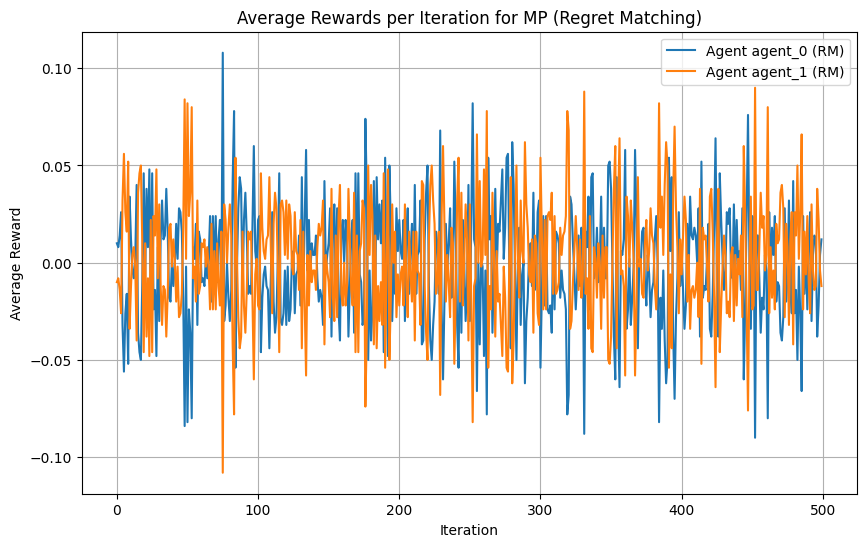

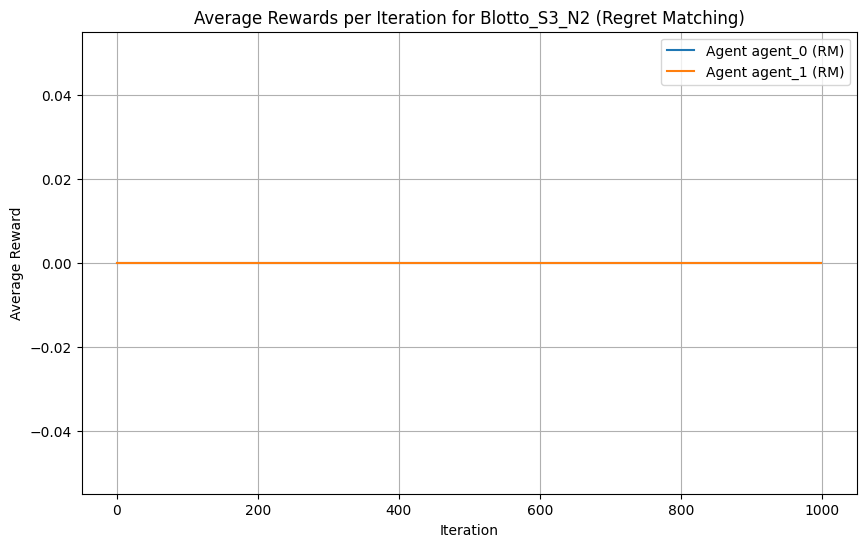

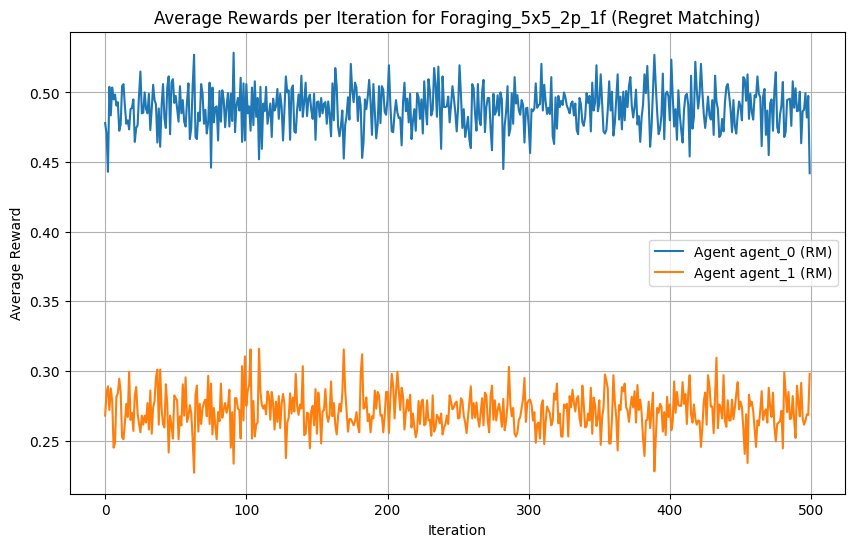

In [7]:
def plot_training_results_rm(game_name, base_path):
    data_path = os.path.join(base_path, game_name, "training_rewards_rm.pkl")
    if not os.path.exists(data_path):
        print(f"No training data found for {game_name} at {data_path}")
        return

    with open(data_path, 'rb') as f:
        training_rewards = pickle.load(f)

    plt.figure(figsize=(10, 6))
    for agent_id, rewards_list in training_rewards.items():
        plt.plot(rewards_list, label=f"Agent {agent_id} (RM)")
    
    plt.title(f"Average Rewards per Iteration for {game_name} (Regret Matching)")
    plt.xlabel("Iteration")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Plot results for the first game trained
if games_to_test:
    first_game_name = games_to_test[0]["name"]
    plot_training_results_rm(first_game_name, TRAINING_DATA_DIR)
    
    second_game_name = games_to_test[1]["name"]
    plot_training_results_rm(second_game_name, TRAINING_DATA_DIR)

    third_game_name = games_to_test[2]["name"]
    plot_training_results_rm(third_game_name, TRAINING_DATA_DIR)

    fourth_game_name = games_to_test[3]["name"]
    plot_training_results_rm(fourth_game_name, TRAINING_DATA_DIR)

## 5. Loading Trained Agents (Example for future use)

This section shows a conceptual way to load the learned policies back into agents.
This would typically be done in a separate notebook for testing or deployment.
The RegretMatching agent's `policy()` method returns its learned average strategy.
To "load" a policy, you would typically set the agent's internal strategy variables if the class supports it,
or use the loaded policy directly for decision-making if the agent is re-instantiated.
The current `RegretMatching` class calculates `learned_policy` on the fly.
For evaluation, you'd create a new agent and then potentially override its `learned_policy` or `curr_policy` if needed,
or ensure it runs enough iterations with the loaded regret/sum_policy values to reconstruct the same learned_policy.

A simpler approach for evaluation is to have the agent use a fixed policy.
The `RegretMatching` agent always chooses actions based on `curr_policy` (which is dynamic during learning)
and `policy()` returns `learned_policy` (average).
For evaluation with a fixed learned policy, one might need to modify the agent or use the policy externally.
Let's assume for now we just want to load the policy array.

In [6]:
def load_agent_policy(game_name: str, agent_id_str: str, base_path: str) -> np.ndarray | None:
    """Loads a learned policy array for an agent from a file."""
    file_path = os.path.join(base_path, game_name, f"agent_{agent_id_str}_rm_policy.pkl")
    if not os.path.exists(file_path):
        print(f"  No policy file found for agent {agent_id_str} in {game_name} at {file_path}")
        return None
    
    try:
        with open(file_path, 'rb') as f:
            policy_array = pickle.load(f)
        print(f"  Loaded policy for agent {agent_id_str} from {file_path}")
        return policy_array
    except Exception as e:
        print(f"  Error loading policy for agent {agent_id_str}: {e}")
        return None

# Example of how you might load policies for a specific game:
# print("\n--- Example: Loading trained policies for RPS (Regret Matching) ---")
# rps_game_load_example = RPS() # Create a fresh game instance

# loaded_policies = {}
# for i, agent_id_key in enumerate(rps_game_load_example.agents):
#     agent_id_simple_load = str(rps_game_load_example.agent_name_mapping[agent_id_key])
#     policy = load_agent_policy("RPS", agent_id_simple_load, TRAINING_DATA_DIR)
#     if policy is not None:
#         loaded_policies[agent_id_key] = policy
#         # To use this policy for evaluation, you would typically create new agents
#         # and make them act according to this fixed policy, rather than their internal RM logic.
#         # This might require a different agent class (e.g., a "FixedPolicyAgent") or modifying
#         # the RegretMatching agent to allow setting a fixed policy for action selection.

# if loaded_policies:
#     print("Loaded policies:")
#     for agent_id, pol in loaded_policies.items():
#         print(f"  Agent {agent_id}: {np.array2string(pol, precision=3)}")

# To evaluate these agents, you would then simulate games where agents pick actions based on these loaded_policies.
# For example, using a simple agent that takes a policy and samples from it:
#
# class FixedPolicyAgent(Agent):
# def __init__(self, game, agent_id, fixed_policy):
# super().__init__(game, agent_id)
# self.fixed_policy = fixed_policy
# def action(self):
# return np.random.choice(len(self.fixed_policy), p=self.fixed_policy)
#
# eval_agents = {}
# if loaded_policies.get("agent_0") is not None and loaded_policies.get("agent_1") is not None:
#     eval_agents["agent_0"] = FixedPolicyAgent(rps_game_load_example, "agent_0", loaded_policies["agent_0"])
#     eval_agents["agent_1"] = FixedPolicyAgent(rps_game_load_example, "agent_1", loaded_policies["agent_1"])
#
#     # Then run play_episode with these eval_agents (and learn=False, verbose=True, render=True)
#     # play_episode(rps_game_load_example, eval_agents, verbose=True, render=True) # play_episode would need to accept generic Agents